In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FuncFormatter
import tqdm

In [2]:
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_style("whitegrid")

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

# for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
#     'font.size' : 11,
# })

In [4]:
def plot(df, omega, title, alpha=0.5, stylek=False):
    fig, axs = plt.subplots(ncols=2)
    fig.set_size_inches(18, 8)
    
    dfx = df[df["omega"] == omega]
    if stylek:
        g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=dfx, ax=axs[0], alpha=alpha, palette=palette)
        g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=dfx, ax=axs[1], alpha=alpha, palette=palette)
    else:
        g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[0], alpha=alpha, palette=palette)
        g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[1], alpha=alpha, palette=palette)
    g2.set_yscale("log")
    g2.set_xscale("log")
    
    
    fig.suptitle(title)
    xlabel = "Num of k-mers"
    ylabel = "Time to process a window, microseconds"
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)
    
    #return fig

In [5]:
#palette = sns.color_palette("Set2", 6)
#palette

# GeoDataViz color palette
# https://github.com/OrdnanceSurvey/GeoDataViz-Toolkit/blob/master/Colours/GDV-colour-palettes-v0.7.json
palette = ["#ff1f5b",
"#00cd6c",
"#009ade",
"#af58ba",
"#ffc61e",
"#f28522",
"#a0b1ba",
"#a6761d"]

In [6]:
print("\n".join(str(v) for v in palette))

#ff1f5b
#00cd6c
#009ade
#af58ba
#ffc61e
#f28522
#a0b1ba
#a6761d


In [7]:
colors = {
    'bb': palette[0],
    'dc': palette[2],
    'dccw': palette[1],
    'bbe': palette[5],
    'bl': palette[4],
}
colors_bg = dict((k, v + "32") for k, v in colors.items())
white = "#ffffff"

In [8]:
def read_dataset(filename):
    df = pd.read_csv(filename)
    df["time"] += 1
    df["num_kmers"] += 1
    df["k"] = df["k"].astype(int)
    df["avg"] = df["time"] / df["num_kmers"]
    return df

In [9]:
def plot_running_mean_time_Z(df, k, **kwargs):
    window_size = kwargs.get("window_size", 1000)
    min_periods = 10
    
    ax = kwargs.get("ax", None)
    all_k = kwargs.get("all_k", False)
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    logy = kwargs.get("logy", False)
    logx = kwargs.get("logx", False)

    handles = []
    labels = []

    omega_values = df["omega"].unique()
    assert(len(omega_values) == 1)
    
    alg_values = df["alg"].unique()

    for alg in alg_values:
        
        # to take all points in the window, may be biased towards large values of |Z|
        # (there is more k-mer poor windows than k-mer rich ones in the same window of running mean)
        #dfa = df[(df["k"] == k) & (df["alg"] == alg)]
        
        # to take average time per value of |Z| first, then do running mean
        dfa = df[(df["k"] == k) & (df["alg"] == alg)]
        dfa = dfa.groupby(["num_kmers"]).mean().reset_index()        
        
        roll = dfa[["num_kmers", "time"]].set_index("num_kmers").sort_index().rolling(window_size, min_periods=min_periods, center=True)
        df_mean = roll.mean().dropna().reset_index().dropna()
        df_sem = roll.sem().dropna().reset_index().dropna()

        ax.fill_between(df_mean["num_kmers"], df_mean["time"]-df_sem["time"], df_mean["time"]+df_sem["time"], color=colors_bg[alg])
        line, = ax.plot(df_mean["num_kmers"], df_mean["time"], color=colors[alg])
        
        handles.append(line)
        labels.append(alg)
    
    labels = [l.upper() for l in labels]
    if legend:
        ax.legend(handles, labels)
    
    ax.set_xlabel("$|\mathcal{Z}|$")
    
    ytext = "Mean processing time, microsec" if ylabel else ""
    ax.set_ylabel(ytext)
    
    if logy:
        ax.set_yscale("log")
    if logx:
        ax.set_xscale("log")
        
    ax.set_title(title)
    
    # remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #sns.despine(ax=ax)
    return ax

In [10]:
#fig, ax = plt.subplots()
#plot_running_mean_time_Z(random, 10, window_size=1000, ax=ax)

In [11]:
def combine_running_mean_time_Z(dfs, **kwargs):
    logy = kwargs.get("logy", True)
    logx = kwargs.get("logx", True)
    
    window_size = kwargs.get("window_size", 1000)
    filename = kwargs.get("filename", None)
    k = kwargs.get("k", 10)

    names, datasets = zip(*dfs)
    num_plots = len(names)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, df in enumerate(datasets):
        ylabel = (i == 0)
        legend = (i == 0)
        print("Plotting", i)
        g1 = plot_running_mean_time_Z(df, k, ax=ax[i], ylabel=ylabel, legend=legend, title=names[i], logy=logy, logx=logx)

    fig.tight_layout()
    
    if filename:
        print("Saving to", filename)
        plt.savefig(filename)   
    #plt.show()
    #return fig

In [12]:
def plot_Z_hist(df, **kwargs):
    k = kwargs.get("k", 10)
    logy = kwargs.get("logy", False)
    ax = kwargs.get("ax", None)
    title = kwargs.get("title", "")
    ylabel = kwargs.get("ylabel", False)
    
    dfk = df[df["k"] == k]
    
    ax.hist(dfk["num_kmers"], log=logy)
    
    ax.set_xlabel("$|\mathcal{Z}|$")
    ytext = "\# of windows" if ylabel else ""
    ax.set_ylabel(ytext)
    ax.set_title(title)
        
    # remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [13]:
def summary_Z_hist(dfs, **kwargs):
    filename = kwargs.get("filename", None)
    logy = kwargs.get("logy", False)
    k = kwargs.get("k", 10)
    
    names, datasets = zip(*dfs)
    num_plots = len(names)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, df in enumerate(datasets):
        ylabel = (i == 0)
        #legend = (i == 0)
        plot_Z_hist(df, k=k, ax=ax[i], ylabel=ylabel, title=names[i], logy=logy)

    fig.tight_layout()
    
    if filename:
        print("Saving to", filename)
        plt.savefig(filename)   

In [14]:
# Mean time per window with differenet number of alive k-mers (fixed k), a rarefied plot
def plot2(df, k, ax=None, **kwargs):
    sample_size = kwargs.get("sample_size", 5000)
    all_k = kwargs.get("all_k", False)
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    logy = kwargs.get("logy", False)
    
    dfk = df if all_k else df[df["k"] == k]
    dfg = dfk.groupby(['num_kmers', 'k', 'omega', 'alg']).mean().reset_index()
    
    max_num_kmers = dfk["num_kmers"].max()
    log_max_num_kmers = np.log10(max_num_kmers)
    
    space = np.linspace(1, max_num_kmers, num=sample_size)
    logspace = np.logspace(1, log_max_num_kmers, num=sample_size)
    
    #space = list(sorted(dfk["num_kmers"].unique()))
    
    if logy:
        df_rarefied = dfg[dfg["num_kmers"].isin(logspace)]
    else:
        df_rarefied = dfg[dfg["num_kmers"].isin(space)]

    num_algs = len(df_rarefied["alg"].unique())
    pal = palette[:num_algs]
    if ax:
        g = sns.scatterplot(data=df_rarefied, x='num_kmers', y='time', hue='alg', ax=ax, palette=pal, legend=legend, edgecolor=None)#edgecolor="black")
    else:
        g = sns.scatterplot(data=df_rarefied, x='num_kmers', y='time', hue='alg', palette=pal, legend=legend)
    g.set_xlabel("$|\mathcal{Z}|$")
    
    ytext = "Mean processing time, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    
    if logy:
        g.set_xscale("log")
        g.set_yscale("log")
        
    g.set_title(title)
    
    # remove borders
    sns.despine()
    
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    return g


In [15]:
def plot_mean_time_k(df, ax=None, **kwargs):
    all_k = kwargs.get("all_k", False)
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    logy = kwargs.get("logy", False)
    
    #dfg = df.groupby(['k', 'omega', 'alg']).mean().reset_index()
    dfg = df.groupby(['k', 'omega', 'alg']).sum().reset_index()
    
    num_algs = len(dfg["alg"].unique())
    pal = palette[:num_algs]
    if ax:
        g = sns.lineplot(data=dfg, x='k', y='time', hue='alg', ax=ax, palette=pal, legend=legend, marker='o')#edgecolor="black")
    else:
        g = sns.lineplot(data=dfg, x='k', y='time', hue='alg', palette=pal, legend=legend, marker='o')
    g.set_xlabel("k")
    
    ytext = "Mean processing time, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    
    g.set_xticks(dfg["k"].unique())
    
    if logy:
        g.set_yscale("log")
        
    g.set_title(title)
    
    # remove borders
    sns.despine()
    
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    return g


In [16]:
def all_mean_time_k(dfs, **kwargs):
    logy = kwargs.get("logy", True)
    logx = kwargs.get("logx", True)
    filename = kwargs.get("filename", None)

    names, datasets = zip(*dfs)
    num_plots = len(names)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)}, font_scale = 1.4)
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, df in enumerate(datasets):
        ylabel = (i == 0)
        legend = (i == 0)
        print("Plotting", i)
        g1 = plot_mean_time_k(df, ax=ax[i], ylabel=ylabel, legend=legend, title=names[i], logy=logy, logx=logx)

    fig.tight_layout()
    
    if filename:
        print("Saving to", filename)
        plt.savefig(filename)   
    #plt.show()
    #return fig

### Neotrop

Measurements made for 100 random ghost nodes of Neotrop. Nodes are the same for both algorithms. All windows of the alignment are considered for every node. Time measurements: microseconds per window

In [42]:
#neotrop = read_dataset("results/neotrop-dccw.csv")
#neotrop = read_dataset("results-ghost/neotrop.csv")
neotrop = read_dataset("results-reproduce/neotrop.csv")

### D155 (HCV)

In [43]:
#d155 = read_dataset("results/d155-dccw.csv")
#d155 = read_dataset("results-ghost/d155.csv")
d155 = read_dataset("results-reproduce/d155.csv")

### Random data

Alignment length = 1000

In [27]:
#random = read_dataset("results/random-dccw.csv")
#random = read_dataset("results-ghost/random.csv")
random = read_dataset("results-reproduce/random.csv")

In [28]:
dfs = list(zip(["Random", "Neotrop", "D155"], [random, neotrop, d155]))

In [29]:
dfg = random.groupby(['k', 'omega', 'alg']).mean().reset_index()
x = dfg[["k", "alg", "num_kmers", "time"]]
#x.to_csv("dccw-stats.tsv", sep="\t")

In [30]:
dfg = neotrop.groupby(['k', 'omega', 'alg']).mean().reset_index()
x = dfg[["k", "alg", "num_kmers", "time"]]
#x.to_csv("neo-stats.tsv", sep="\t")

In [31]:
dfg = d155.groupby(['k', 'omega', 'alg']).mean().reset_index()
x = dfg[["k", "alg", "num_kmers", "time"]]
#x.to_csv("d155-stats.tsv", sep="\t")

# Plots for the paper
## Plot 1: fix k, vary |Z|. Mean running time

Let's fix k and see how time depends on the size of |Z|. For one value of |Z| on X-axis, show the mean time of generating such windows.

In [269]:
#fig, ax = plt.subplots()
#plot_running_mean_time_Z(random, 10, window_size=100, ax=ax, 
#                         logy=True, logx=True, legend=True, 
#                         title="Mean processing time per window | Random")
#fig.savefig("img/test.pdf")

In [270]:
#fig, ax = plt.subplots()
#plot_running_mean_time_Z(neotrop, 10, window_size=250, ax=ax, 
#                         logy=True, logx=True, legend=True,
#                         title="Mean processing time per window | Neotrop")

In [271]:
#fig, ax = plt.subplots()
#plot_running_mean_time_Z(d155, 10, window_size=250, ax=ax, 
#                         logy=True, logx=True, legend=True,
#                         title="Mean processing time per window | D155")

In [272]:
#combine_running_mean_time_Z(dfs, k=10, window_size=100, 
#                            logy=True, logx=True)
                            #filename="img/mean-average-mean-Z-k10.pdf")

In [273]:
#combine_running_mean_time_Z(dfs, k=10, window_size=1, 
#                            logy=True, logx=True)
#                            #filename="img/mean-average-mean-Z-k10.pdf")

In [274]:
#summary_Z_hist(dfs, logy=True)#, filename="img/Z-hist.pdf"

## Plot 2: mean running time per dataset (fixed k and omega)

Plotting 0
Plotting 1
Plotting 2
Saving to img/total-time-per-k.pdf


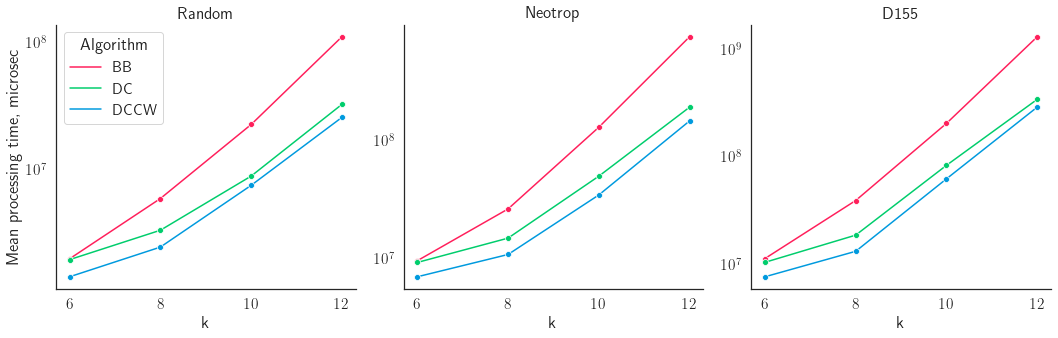

In [43]:
#all_mean_time_k(dfs, logy=True, filename="img/mean-time-per-k.pdf")
all_mean_time_k(dfs, logy=True, filename="img/total-time-per-k.pdf")
#all_mean_time_k(dfs, logy=True)

In [28]:
def original_meantime_Z_plot(df, k, **kwargs):
    logy = kwargs.get("logy", False)
    logx = kwargs.get("logx", False)
    ax = kwargs.get("ax", None)
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    maxZ = kwargs.get("maxZ", None)
    minZ = kwargs.get("minZ", None)
    
    dfa = df[(df["k"] == k)]
    
    #dfa = dfa[dfa["alg"] != "bb"]
    num_algs = len(dfa["alg"].unique())
    
    if maxZ:
       dfa = dfa[dfa["num_kmers"] <= maxZ] 
    if minZ:
       dfa = dfa[dfa["num_kmers"] >= minZ] 

    df_mean = dfa.groupby(["num_kmers", "alg"]).mean().reset_index()   
    #df_mean = dfa.groupby(["num_kmers", "alg"]).sum().reset_index()   

    s = sns.scatterplot(data=df_mean, x="num_kmers", y="time", hue="alg", 
                        palette=palette[:num_algs], s=10, linewidth=0,
                        ax=ax, legend=legend)
    if logx:
        s.set(xscale="log")
    if logy:
        s.set(yscale="log")
        
    ax.set_xlabel("$|\mathcal{Z}|$")
    
    ytext = "Mean processing time, microsec" if ylabel else ""
    ax.set_ylabel(ytext)
    ax.set_title(title)
    
    # remove borders
    sns.despine()
    
    if legend:
        leg = ax.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())


In [29]:
def alldata_meantime_Z(dfs, **kwargs):
    filename = kwargs.get("filename", None)
    k = kwargs.get("k", 10)
    logy = kwargs.get("logy", True)
    logx = kwargs.get("logx", True)
    maxZ = kwargs.get("maxZ", None)
    minZ = kwargs.get("minZ", None)

    names, datasets = zip(*dfs)
    num_plots = len(names)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)}, font_scale = 1.4)
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, df in enumerate(datasets):
        ylabel = (i == 0)
        legend = (i == 0)
        print("Plotting", i)
        original_meantime_Z_plot(df, k, ax=ax[i], ylabel=ylabel, legend=legend, title=names[i], logy=logy, logx=logx, maxZ=maxZ, minZ=minZ)

    fig.tight_layout()
    
    if filename:
        print("Saving to", filename)
        plt.savefig(filename)   

In [ ]:
#alldata_meantime_Z(dfs, k=10, logy=False, logx=False, maxZ=10 * 4)

In [ ]:
#alldata_meantime_Z(dfs, k=10, logy=False, logx=False, minZ=4000)

In [279]:
#alldata_meantime_Z(dfs, k=10, logy=False, logx=False)

In [54]:
def sum_stats(df):
    x = df.groupby(["k", "omega", "alg"]).sum().reset_index()
    x.time /= 1000000
    return x.drop(columns=["num_kmers", "position", "avg"])

In [58]:
x = sum_stats(neotrop)
x.to_csv("neotrop-time.tsv", sep="\t")
x

,k,omega,alg,time
0,6,1.5,bb,9.594890
1,6,1.5,dc,9.278081
2,6,1.5,dccw,7.016632
3,8,1.5,bb,26.383683
4,8,1.5,dc,14.920704
5,8,1.5,dccw,10.843992
6,10,1.5,bb,130.187314
7,10,1.5,dc,50.058434
8,10,1.5,dccw,34.686739
9,12,1.5,bb,762.198699


In [59]:
x = sum_stats(d155)
x.to_csv("d155-time.tsv", sep="\t")
x

,k,omega,alg,time
0,6,1.5,bb,11.353163
1,6,1.5,dc,10.475716
2,6,1.5,dccw,7.689708
3,8,1.5,bb,39.331135
4,8,1.5,dc,18.750299
5,8,1.5,dccw,13.264904
6,10,1.5,bb,204.925997
7,10,1.5,dc,83.536984
8,10,1.5,dccw,62.558589
9,12,1.5,bb,1308.669279


Plotting 0
Plotting 1
Plotting 2


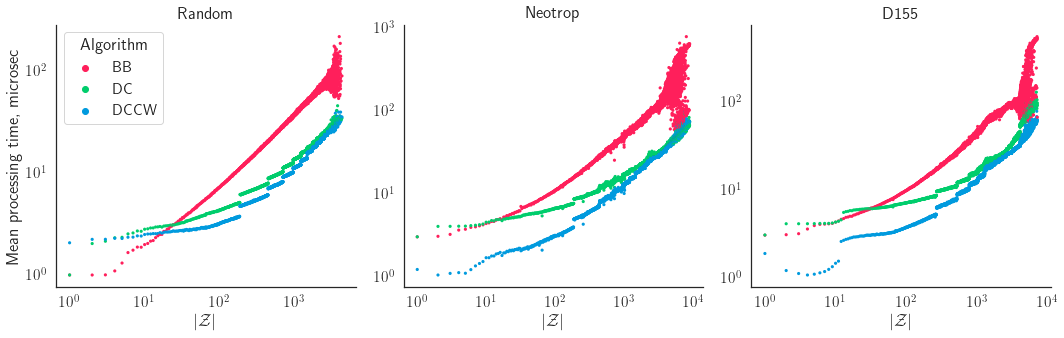

In [30]:
alldata_meantime_Z(dfs, k=10, logy=True, logx=True)

Plotting 0
Plotting 1
Plotting 2


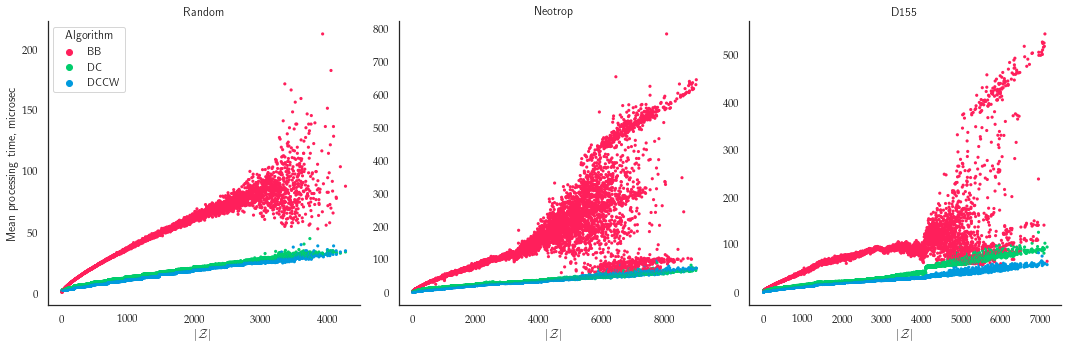

In [96]:
alldata_meantime_Z(dfs, k=10, logy=False, logx=False)

Plotting 0
Plotting 1
Plotting 2
Saving to img/original-meantime.pdf


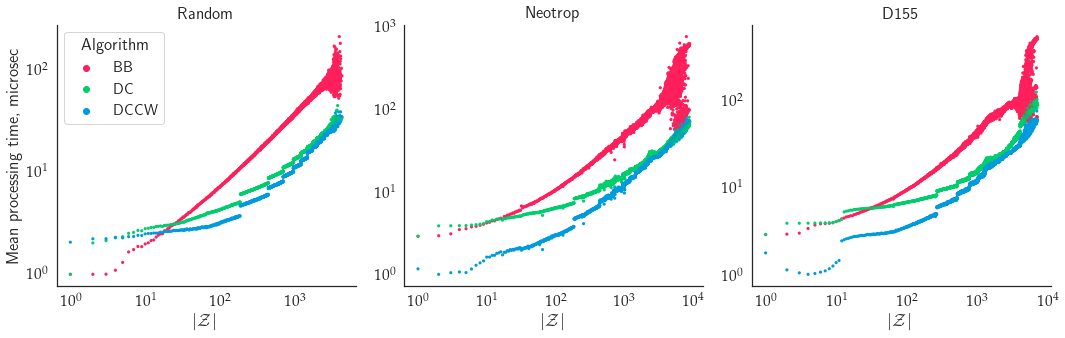

In [289]:
alldata_meantime_Z(dfs, k=10, logy=True, logx=True, filename="img/original-meantime.pdf")
#alldata_meantime_Z(dfs, k=10, logy=True, logx=True)

Plotting 0
Plotting 1
Plotting 2


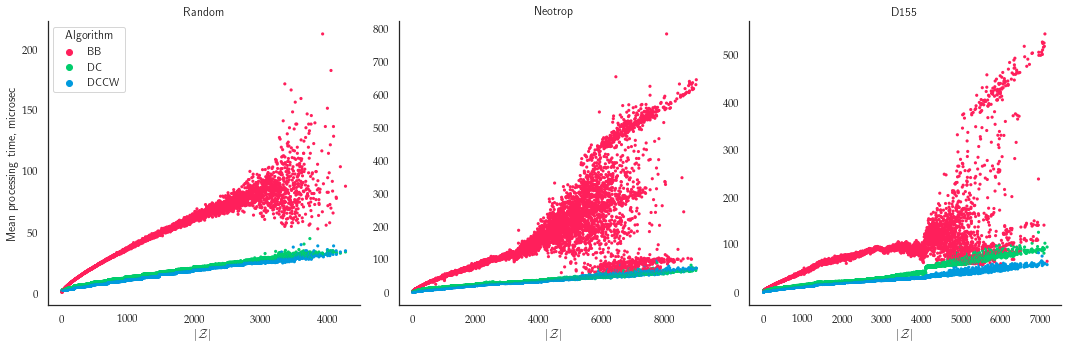

In [231]:
alldata_meantime_Z(dfs, k=10, logy=False, logx=False)

In [149]:
def Z_hist(df, **kwargs):
    logy = kwargs.get("logy", False)
    logx = kwargs.get("logx", False)
    k = kwargs.get("k", 10)
    ax = kwargs.get("ax", None)
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    
    alg_values = df["alg"].unique()
    alg = alg_values[0]        
    dfa = df[(df["k"] == k) & (df["alg"] == alg)]
    dfa = dfa.groupby(["num_kmers"]).count().reset_index()        

    sns.scatterplot(x=dfa["num_kmers"], y=dfa["time"], color=colors[alg], ax=ax,
                   s=10, linewidth=0)
    
    ax.set_xlabel("$|\mathcal{Z}|$")
    ytext = "\# windows" if ylabel else ""
    ax.set_ylabel(ytext)
    ax.set_title(title)
    
    # remove borders
    sns.despine()
    
    if logy:
        ax.set_yscale("log")
    if logx:
        ax.set_xscale("log")
        
    print("Total windows:", dfa["time"].sum())



In [290]:
def all_Z_hists(dfs, **kwargs):
    filename = kwargs.get("filename", None)
    k = kwargs.get("k", 10)
    logy = kwargs.get("logy", True)
    logx = kwargs.get("logx", True)
    
    names, datasets = zip(*dfs)
    num_plots = len(names)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)}, font_scale = 1.4)
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, df in enumerate(datasets):
        ylabel = (i == 0)
        legend = (i == 0)
        print("Plotting", i)
        Z_hist(df, k=k, ax=ax[i], ylabel=ylabel, legend=legend, title=names[i], logy=logy, logx=logx)

    fig.tight_layout()
    
    if filename:
        print("Saving to", filename)
        plt.savefig(filename)   

In [286]:
#all_Z_hists(dfs, k=10, logx=False, logy=True, filename="img/all-Z-hists.pdf")

Plotting 0
Total windows: 994000
Plotting 1
Total windows: 5740062
Plotting 2
Total windows: 5861244


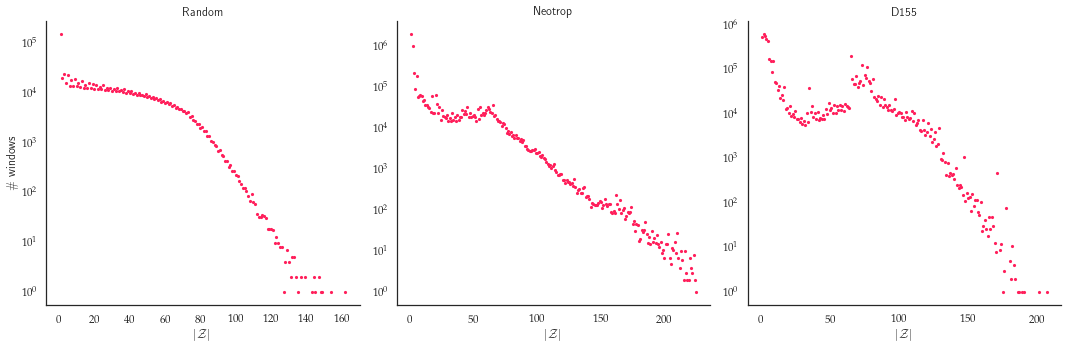

In [154]:
all_Z_hists(dfs, k=6, logx=False, logy=True)

Plotting 0
Total windows: 992000
Plotting 1
Total windows: 5735978
Plotting 2
Total windows: 5860016


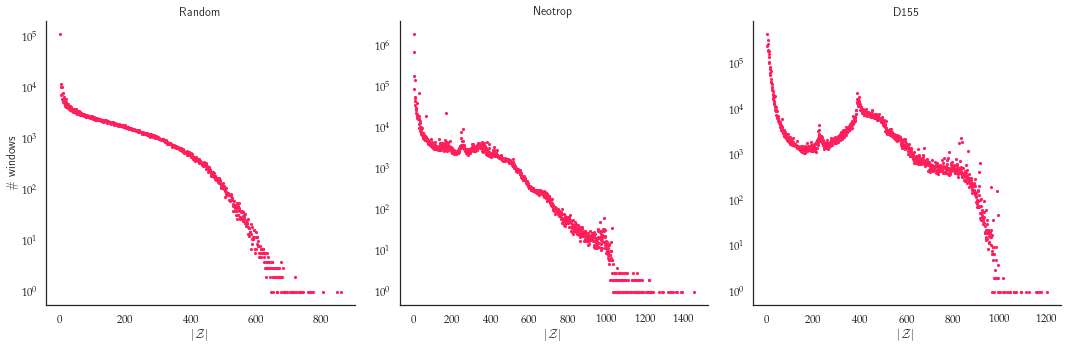

In [155]:
all_Z_hists(dfs, k=8, logx=False, logy=True)

Plotting 0
Total windows: 990000
Plotting 1
Total windows: 5731894
Plotting 2
Total windows: 5858788
Saving to all-Z-hists.pdf


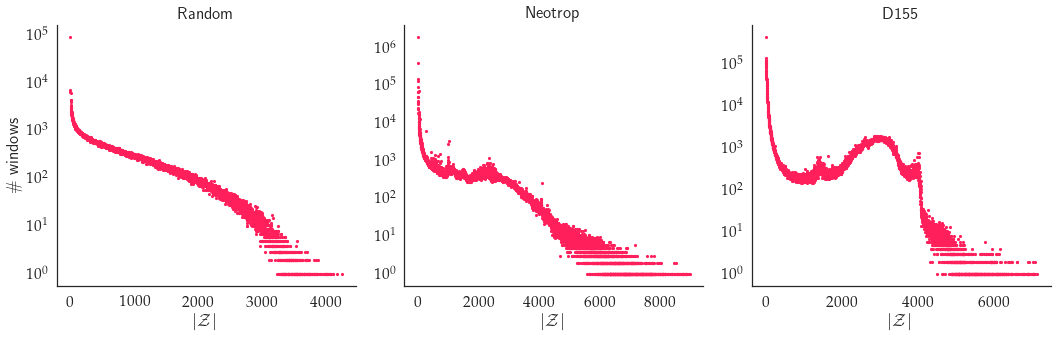

In [291]:
all_Z_hists(dfs, k=10, logx=False, logy=True, filename="all-Z-hists.pdf")

Plotting 0
Total windows: 988000
Plotting 1
Total windows: 5727810
Plotting 2
Total windows: 5857560


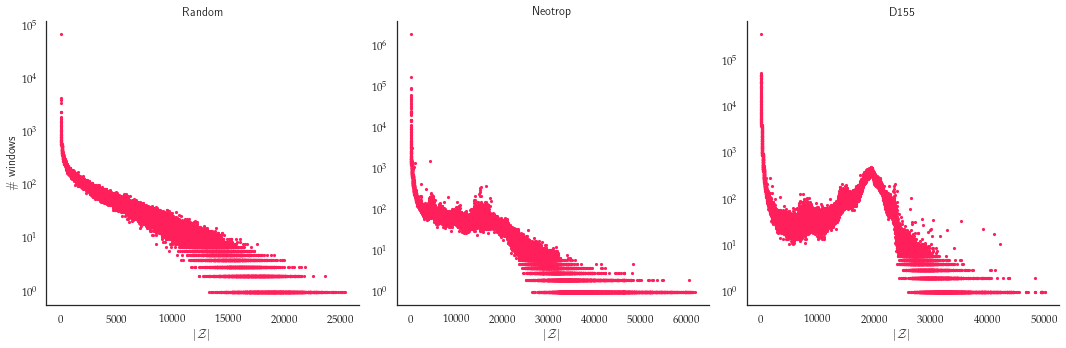

In [157]:
all_Z_hists(dfs, k=12, logx=False, logy=True)

In [301]:
df = random
#df = neotrop
#df = d155
dfg = df.groupby(['k', 'omega', 'alg']).mean().reset_index()
dfg

,k,omega,alg,num_kmers,time,position,avg
0,6,1.5,bb,27.172709,1.962990,496.5,0.247688
1,6,1.5,dc,27.172712,1.933281,496.5,0.265290
2,6,1.5,dccw,27.172712,1.413942,496.5,0.254142
3,8,1.5,bb,125.916074,5.904144,495.5,0.190451
4,8,1.5,dc,125.916070,3.311173,495.5,0.193044
5,8,1.5,dccw,125.916070,2.434928,495.5,0.238556
6,10,1.5,bb,603.687477,22.837373,494.5,0.153836
7,10,1.5,dc,603.687496,8.911344,494.5,0.145103
8,10,1.5,dccw,603.687495,7.529429,494.5,0.240171
9,12,1.5,bb,2982.380904,113.439311,493.5,0.130440


In [303]:
for k in dfg.k.unique():
    dfk = dfg[dfg["k"] == k]
    bb = dfk[dfk["alg"] == "bb"]
    dc = dfk[dfk["alg"] == "dc"]
    dccw = dfk[dfk["alg"] == "dccw"]
    ratio = float(dc.time) / float(dccw.time)
    print("k = ", k, " DC / DCCW ratio:",  ratio)

k =  6  DC / DCCW ratio: 1.3672987737805042
k =  8  DC / DCCW ratio: 1.359864770483666
k =  10  DC / DCCW ratio: 1.183535178796735
k =  12  DC / DCCW ratio: 1.2678767543197218


9    0.193235
Name: time, dtype: float64

In [357]:
def get_dccw_improvement_factors(df):
    df_10 = df[df["k"] == 10]
    dfg = df_10.groupby(['omega', 'num_kmers', 'alg']).mean().reset_index()
    dc = dfg[dfg["alg"] == "dc"]
    dccw = dfg[dfg["alg"] == "dccw"]
    factors = np.array(dc.time) / np.array(dccw.time)
    return pd.DataFrame({"num_kmers": dc.num_kmers, "factor": factors })

In [362]:
dfr = get_dccw_improvement_factors(random)
dfr["dataset"] = "random"
dfr["factor"].max()

1.5

In [ ]:
dfn = get_dccw_improvement_factors(neotrop)
dfn["dataset"] = "neotrop"
dfn["factor"].max()

3.8613934222672044

In [365]:
dfd = get_dccw_improvement_factors(d155)
dfd["dataset"] = "d155"
dfd["factor"].max()

3.8317823711877903

In [375]:
df_all = pd.concat([dfr, dfn, dfd])
df_all.to_csv("k10-dccw-factors.tsv", sep="\t")

In [385]:
df_all_max = df_all.groupby(["dataset"]).max().reset_index().drop(columns=["num_kmers"])
df_all_max.to_csv("k10-dccw-max-factor.tsv", sep="\t")
#df_all_max

<AxesSubplot:xlabel='num_kmers', ylabel='time'>

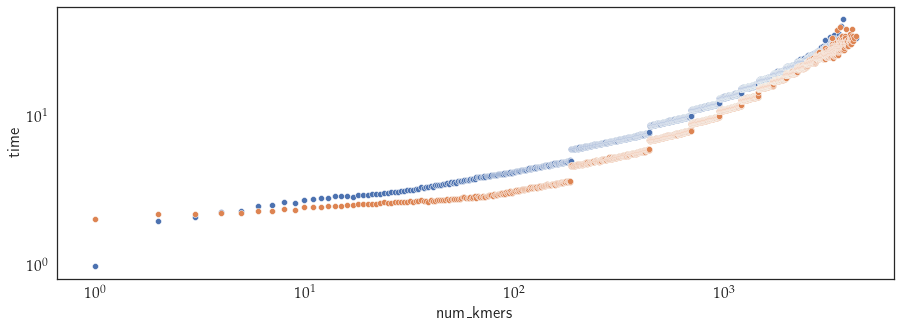

In [351]:
ax = sns.scatterplot(x=dc.num_kmers, y=dc.time, ci=None)
ax.set_yscale("log")
ax.set_xscale("log")

sns.scatterplot(ax=ax, x=dccw.num_kmers, y=dccw.time, ci=None)